<a href="https://colab.research.google.com/github/Tahedi1/Workshop-plant-diseases-classifcation/blob/main/Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the required packges

In [1]:
import tensorflow as tf
print(tf.__version__)
 
from tensorflow.keras.applications import VGG16
 
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense
 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img,img_to_array,array_to_img
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model

import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sn
import random
import matplotlib.cm as cm

2.8.2


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Exploring data

Data exploration is very important to get idea about :

*   Dataset classes
*   Number of images in each class
*   Nature of images
*   ...



In [3]:
#!gdown "https://drive.google.com/u/0/uc?export=download&confirm=Eptv&id=0B_voCy5O5sXMTFByemhpZllYREU" 
!gdown "https://drive.google.com/uc?export=download&id=1sEyTdRbQ3wdxHZt-Ab-OPvXb1c_S453Z"
!tar -xf /content/PlantVillage.tar.gz

Downloading...
From: https://drive.google.com/uc?export=download&id=1sEyTdRbQ3wdxHZt-Ab-OPvXb1c_S453Z
To: /content/PlantVillage.tar.gz
100% 830M/830M [00:19<00:00, 43.2MB/s]


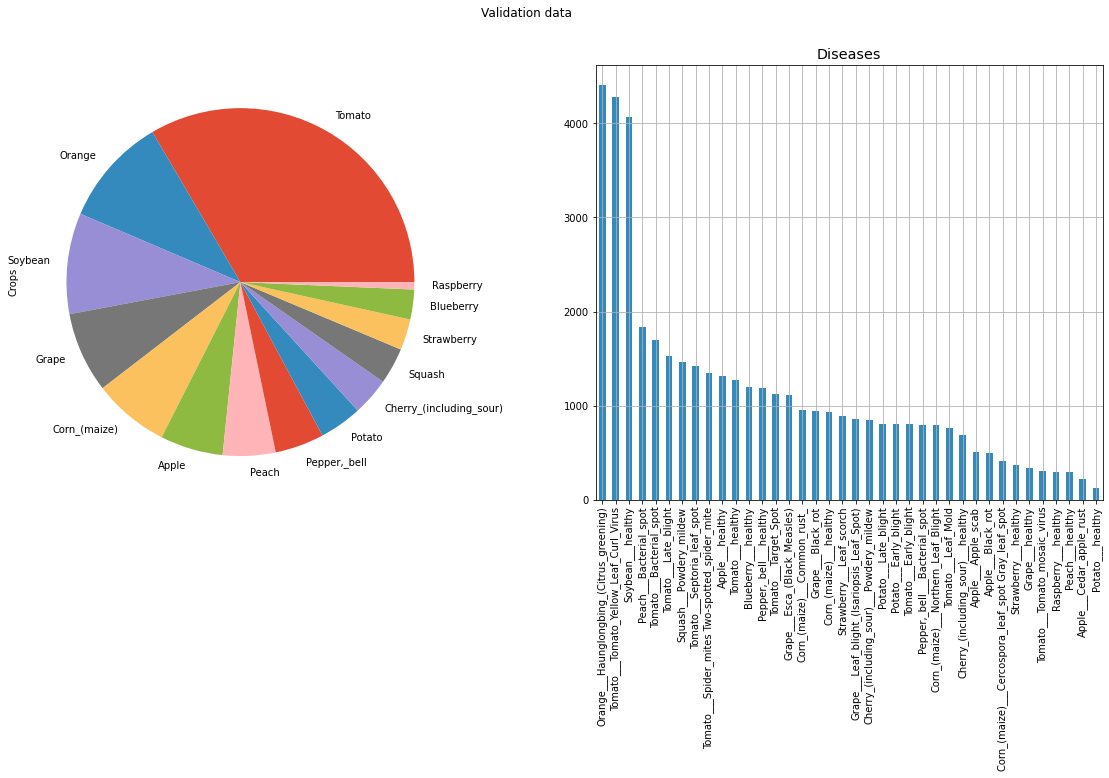

In [4]:
train_path = '/content/PlantVillage/train'
lists = os.listdir(train_path)
diseases = []
crops = []
file_lst = []
for folder in lists:
    files = os.listdir(os.path.join(train_path,folder))
    files = [folder+'/'+file  for file in files]
    file_lst.extend(files)
    if(folder != 'background'): 
      diseases.extend([folder for i in range(len(files))])
      crops.extend([folder.split(sep='___')[0] for i in range(len(files))])
train_df = pd.DataFrame(list(zip(file_lst,crops,diseases)),columns =["Paths","Crops","Diseases"])

fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(20,8))
with plt.style.context('ggplot'):
  train_df['Crops'].value_counts().plot(kind='pie', title='Validation data',ax = axes[0],subplots=True)
  train_df['Diseases'].value_counts().plot(kind='bar', color='C1',title='Validation data',ax = axes[1],subplots=True)

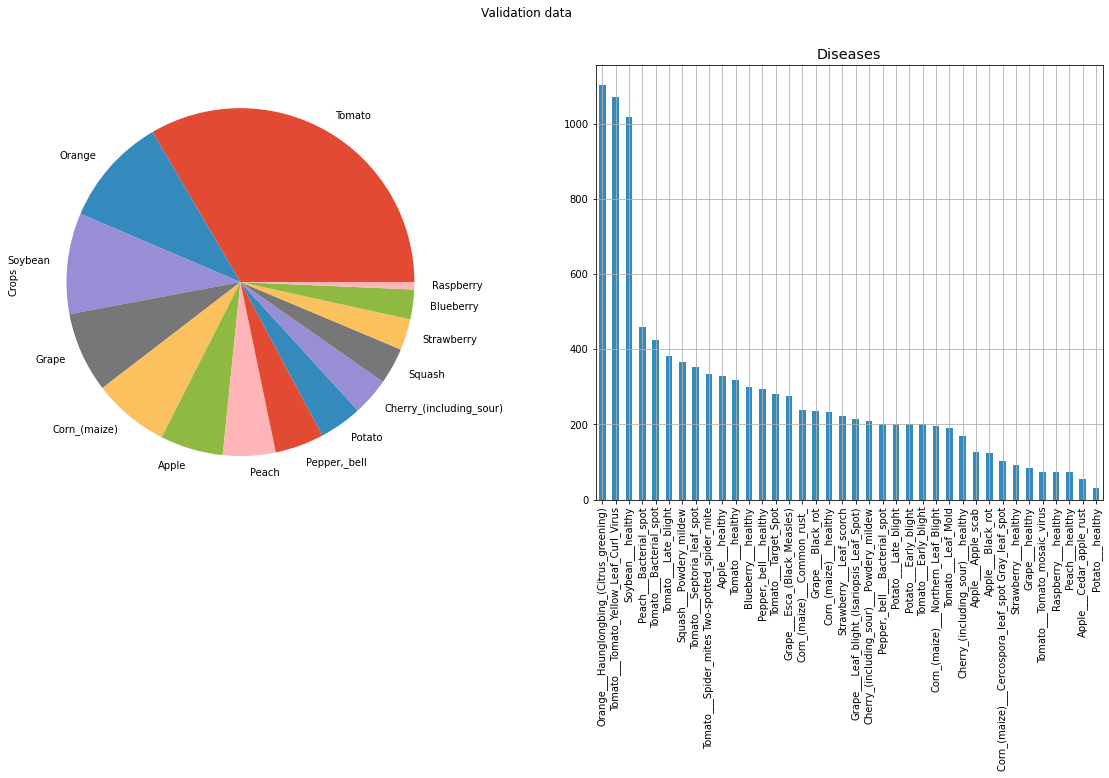

In [5]:
validation_path = '/content/PlantVillage/val'
lists = os.listdir(validation_path)
diseases = []
crops = []
file_lst = []
for folder in lists:
    files = os.listdir(os.path.join(validation_path,folder))
    files = [folder+'/'+file  for file in files]
    file_lst.extend(files)
    if(folder != 'background'): 
      diseases.extend([folder for i in range(len(files))])
      crops.extend([folder.split(sep='___')[0] for i in range(len(files))])
validation_df = pd.DataFrame(list(zip(file_lst,crops,diseases)),columns =["Paths","Crops","Diseases"])

fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(20,8))
with plt.style.context('ggplot'):
  validation_df['Crops'].value_counts().plot(kind='pie', title='Validation data',ax = axes[0],subplots=True)
  validation_df['Diseases'].value_counts().plot(kind='bar', color='C1',title='Validation data',ax = axes[1],subplots=True)

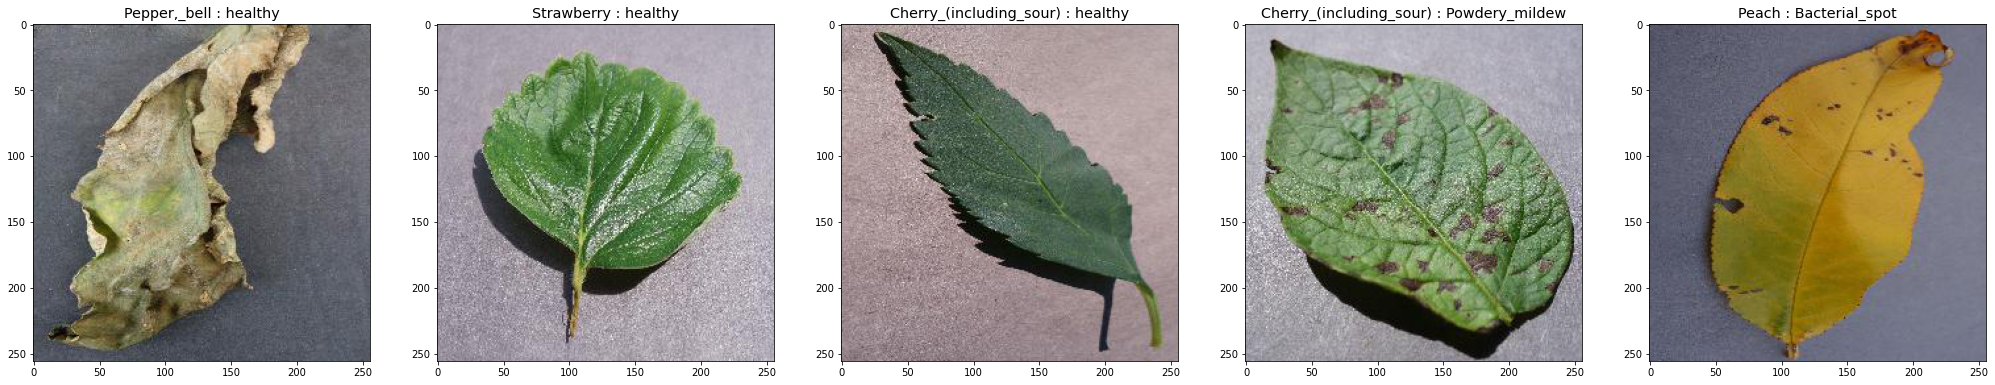

In [6]:
number_images =5

selected_images_df = train_df.sample(number_images)

plt.rcParams["axes.grid"] = False
figure, ax = plt.subplots(1, number_images, figsize=(number_images*7,10)) 
plt.style.use('ggplot')
idx=0
for index, row in selected_images_df.iterrows():
  image = Image.open(os.path.join(train_path,row.Paths))

  disease = row.Diseases.split('___')[1]
  ax[idx].set_title(row.Crops + " : " + disease)
  ax[idx].imshow(image)
  idx= idx + 1

## Loading the Data for training


The keras function [**`ImageDataGenerator.flow_from_directory()`**](https://keras.io/api/preprocessing/image/) will be the interface between the dataset in disk and the training loop. 
it allows: 
*   Get images from disc in batches **Batch1**, **Batch2**, ...,**BatchN** 
*   Applies pre-processing operations on images
*  [Data augmentation]



In [7]:
batch_size = 32
image_size = (224,224)

In [8]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                  train_path,
                  target_size=image_size,
                  batch_size=batch_size
                  )

Found 44016 images belonging to 39 classes.


In [9]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = train_datagen.flow_from_directory(
                  validation_path,
                  target_size=image_size,
                  batch_size=2*batch_size,
                  shuffle=False,
                  )

Found 11004 images belonging to 39 classes.


# Model construction

In [10]:
class_number = train_generator.num_classes

## Downloading the Pretrained Model

The [ImageNet pre-trained models](https://keras.io/api/applications/vgg/#vgg16-function) are often good choices for computer vision transfer learning, as they have learned to classify various different types of images. In doing this, they have learned to detect many different types of [features](https://developers.google.com/machine-learning/glossary#) that could be valuable in image recognition. 

Let us start by downloading the pre-trained model. Again, this is available directly from the Keras library. As we are downloading, there is going to be an important difference. The last layer of an ImageNet model is a [dense layer](https://developers.google.com/machine-learning/glossary#dense-layer) of 1000 units, representing the 1000 possible classes in the dataset. In our case, we want it to make a different classification: 38 plant diseases? Because we want the classification to be different, we are going to remove the last layer of the model. We can do this by setting the flag `include_top=False` when downloading the model. After removing this top layer, we can add new layers that will yield the type of classification that we want:

In [11]:
base_model = VGG16(include_top =False,input_shape = (224,224,3))

58900480/58889256 [==============================] - 0s 0us/step


## Adding New Layers


We can now add the new trainable layers to the pre-trained model. They will take the features from the pre-trained layers and turn them into predictions on the new dataset. We will add two layers to the model. First will be a pooling layer like we saw in our earlier [convolutional neural network](https://developers.google.com/machine-learning/glossary#convolutional_layer). (If you want a more thorough understanding of the role of pooling layers in CNNs, please read [this detailed blog post](https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/#:~:text=A%20pooling%20layer%20is%20a,Convolutional%20Layer). We then need to add our final layer, which will classify plant diseases. This will be a densely connected layer with one output.

In [12]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(class_number, activation='softmax')(x)
model = Model(base_model.input, predictions)

## Model graph visualization

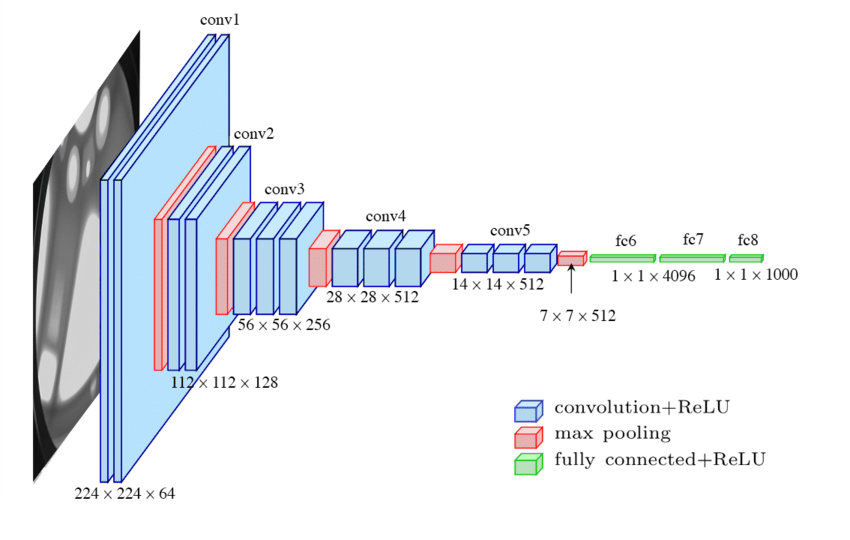

In [13]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

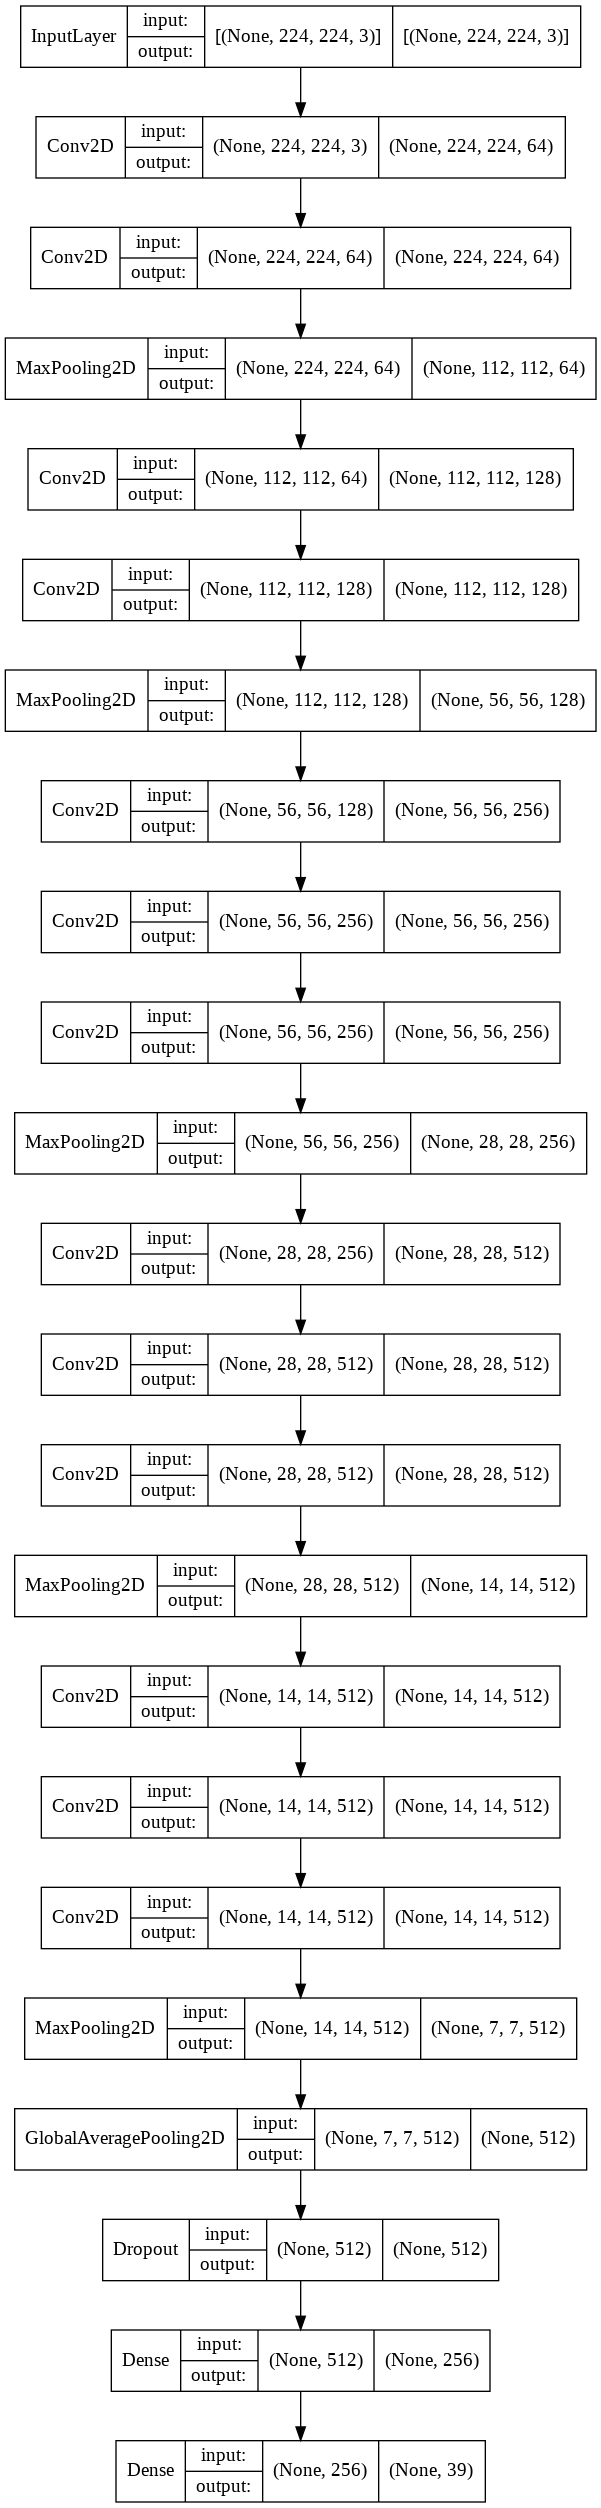

In [14]:
plot_model(model, show_shapes=True, show_layer_names=False)

## Compiling the Model

We need to compile the model with loss and metrics options. We have to make some different choices here.

Again, more details are to follow, but the final step we need to do before we can actually train our model with data is to [compile](https://keras.io/api/models/model_training_apis/#compile) it. Here we specify a [loss function](https://developers.google.com/machine-learning/glossary#loss) which will be used for the model to understand how well it is performing during training. We also specify that we would like to track `accuracy` while the model trains:

In [15]:
model.compile(optimizer=optimizers.SGD(learning_rate=1e-3, momentum=0.9), 
              loss='categorical_crossentropy' ,
              metrics = ['accuracy']
              )

## Training the Model

Now that we have prepared training and validation data, and a model, it's time to train our model with our training data, and verify it with its validation data.

"Training a model with data" is often also called "fitting a model to data." Put this latter way, it highlights that the shape of the model changes over time to more accurately understand the data that it is being given.

When fitting (training) a model with Keras, we use the model's [fit](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) method. It expects the following arguments:

* The training data
* The labels for the training data
* The number of times it should train on the entire training dataset (called an *epoch*)
* The validation or test data, and its labels

Run the cell below to train the model. We will discuss its output after the training completes:

In [ ]:
nbr_epochs = 1
history=model.fit(train_generator,
          epochs=nbr_epochs,
          validation_data=validation_generator
)

 229/1376 [===>..........................] - ETA: 7:46 - loss: 2.2187 - accuracy: 0.4112

## Saving the model & results

In [ ]:
target_dir = '/content/drive/MyDrive/Workshop-09/'
os.mkdir(target_dir)
model.save(os.path.join(target_dir+'/my_model.h5'))

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.to_csv(os.path.join(target_dir+'/hystory.csv'),index=False)